# Проект: классификация

In [471]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest, f_regression
import plotly.express as px

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [472]:
# Загружаем исходные данные:
data = pd.read_csv('Data/bank_fin.csv', sep = ';')
# Выводим на экран данные:
data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [473]:
# Исследуйте данные на предмет пропусков.
# Где есть пропущенные значения? Сколько их?

data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [474]:
# Есть ли в признаке job пропущенные значения?
# Возможно, они обозначены каким-то специальным словом?

print(data['job'].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


### Задание 3

In [475]:
# Преобразуйте признак balance таким образом, чтобы
# он корректно считывался, как вещественное число (float):

data['balance'] = data['balance'].astype(str)

data['balance']  = data['balance'].apply(
    lambda x: str(x.replace("$","").replace(" ", "").split(',')[0]))
data['balance'] = data['balance'].astype(float)
print(round(data['balance'].mean(), 3))

data.head(5)

1529.129


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Задание 4

In [476]:
# Обработайте пропуски в признаки balance,
# заменив их на медианные значения по данному признаку:

data['balance'].fillna(data['balance'].median(), inplace=True)
print(round(data['balance'].mean(), 3))

1526.936


### Задание 5

In [477]:
# Обработайте пропуски в категориальных признаках
# job и education, заменив их на модальные значения:

mode_job = data['job'].mode()
mode_ed = data['education'].mode()

data['job'] = data['job'].replace('unknown', 'management')
data['education'] = data['education'].replace('unknown', 'secondary')

av_balance = data[(data['job'] == 'management') 
                  & (data['education'] == 'secondary')]['balance'].mean()
print(round(av_balance, 3))

1598.883


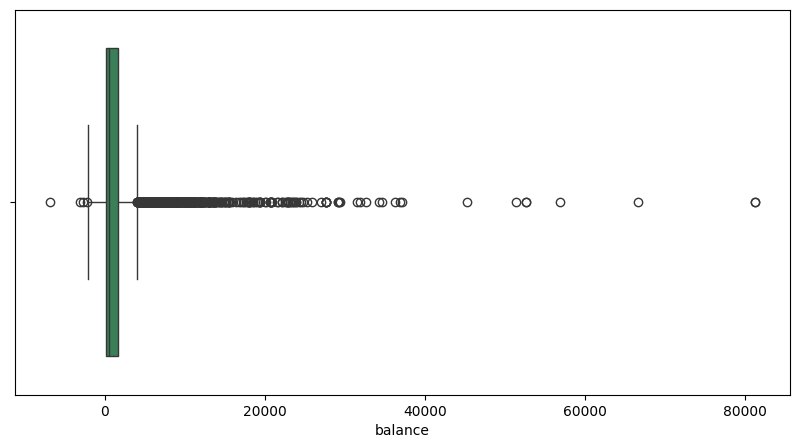

In [478]:
# Построим график:

fig = plt.figure(figsize = (10, 5))
sns.boxplot(
    data = data,
    x = 'balance',
    orient = 'h',
    color = 'seagreen'
)
# Выводим результат на экран:            
fig.show()

### Задание 6

In [479]:
# удалите все выбросы для признака balance:

display(data['balance'].describe())

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

In [480]:
# Вычисление границ IQR:

Q1, Q3 = data['balance'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
print(lower_bound, upper_bound)

# Отсеивание выбросов:

data = data[(data['balance'] >= lower_bound) & (data['balance'] <= upper_bound)]

-2241.0 4063.0


In [481]:
display(data['balance'].describe())

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

## Часть 2:  Разведывательный анализ

### Задание 1

In [482]:
# Изучите соотношение классов в ваших данных
# на предмет несбалансированности,
# проиллюстрируйте результат:

data['age'].max()
data['job'].value_counts()
display(data['deposit'].describe())
data['deposit'].value_counts()

count     10105
unique        2
top          no
freq       5424
Name: deposit, dtype: object

deposit
no     5424
yes    4681
Name: count, dtype: int64

In [483]:
# Построим график:

px.histogram(data,
             x = 'deposit',
             # Выведем количество наблюдений в каждом столбце:
             text_auto = True,
             # Цвет графика:
             color_discrete_sequence = ['seagreen'],
             # Высота графика:
             height = 400,
             # Заголовок графика: 
             title = '''Количество клиентов открывших депозит:'''
             )

### Задания 2 и 3

In [484]:
# Рассчитайте описательные статистики для количественных переменных,
# проинтерпретируйте результат:

data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [485]:
# Рассчитайте описательные статистики для категориальных переменных,
# проинтерпретируйте результат:

data.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


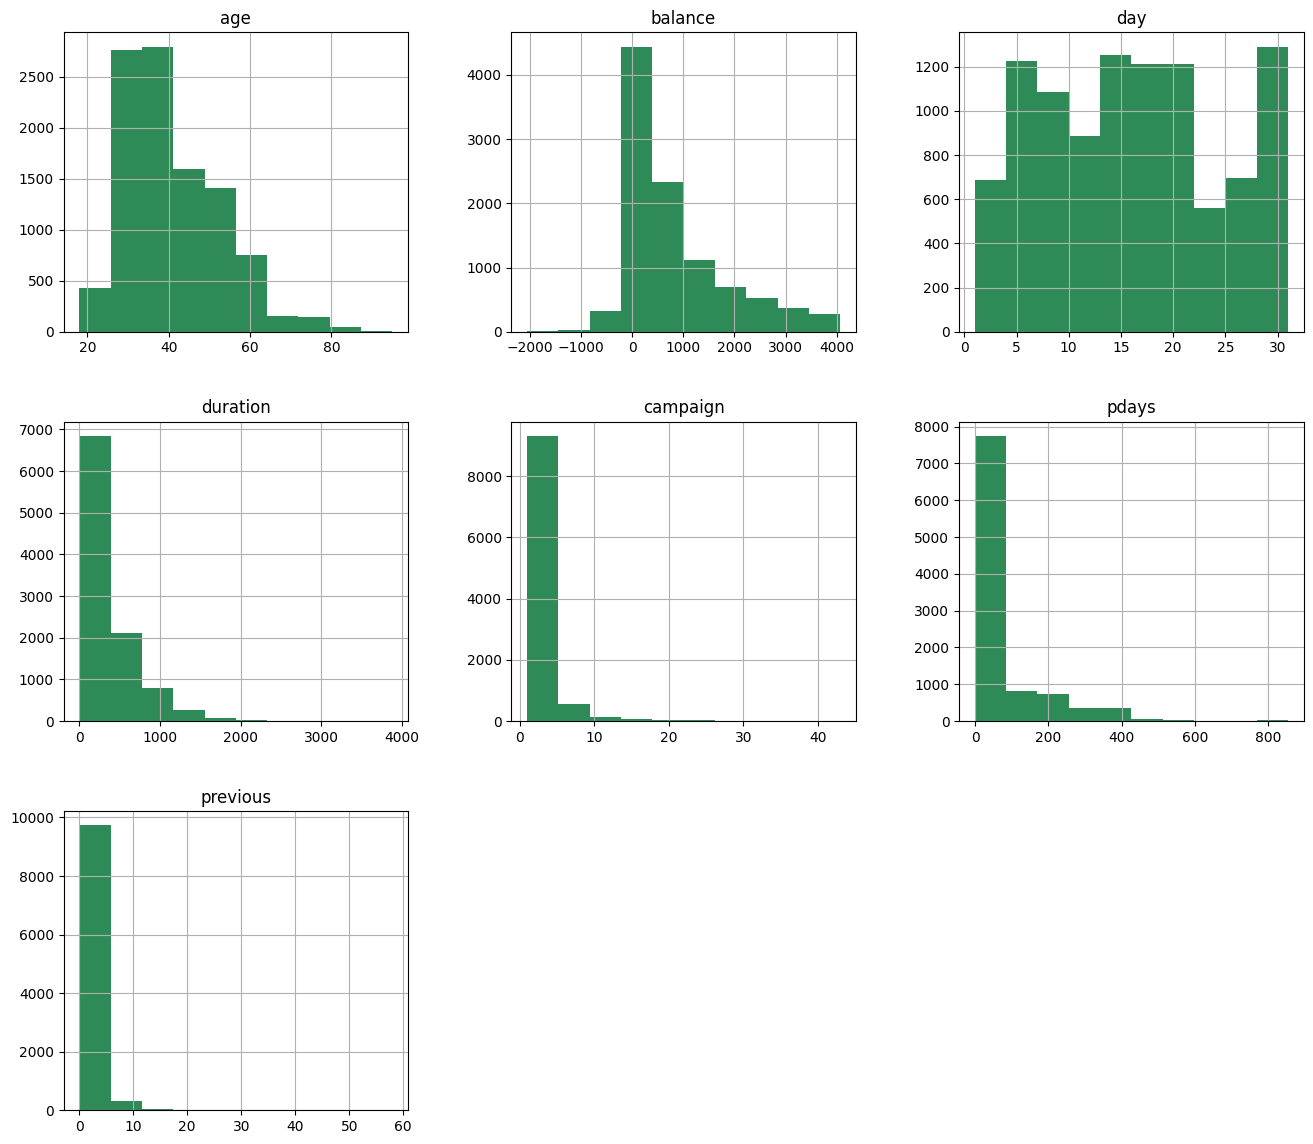

In [486]:
# Постройте визуализации, иллюстрирующие результаты:

data.hist(figsize = (16,14),
          # Цвет графика:
          color = ['seagreen'])

# Выводим результат на экран:
fig.show()

### Задание 6

In [487]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании
# успех в текущей превалирует над количеством неудач.

types = data.groupby('poutcome')['deposit'].value_counts().unstack()

fig = px.bar(types,
    barmode = 'group',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )

# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Статус предыдущей маркетинговой кампании:')
fig.update_yaxes(title_text = 'Количество клиентов:')

# Выводим результат на экран:           
fig.show()

### Задание 7

In [488]:
# Узнайте, в каком месяце чаще всего отказывались
# от предложения открыть депозит:

data['month'].value_counts()

month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64

### Задание 8

In [489]:
# Создайте возрастные группы и определите, в каких группах более
# склонны открывать депозит, чем отказываться от предложения:

data['AgeCategory'] = pd.cut(data['age'], (0, 30, 40, 50, 60, 9999),
                             labels = ['<30', '30-40', '40-50', '50-60', '60+'])

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,AgeCategory
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


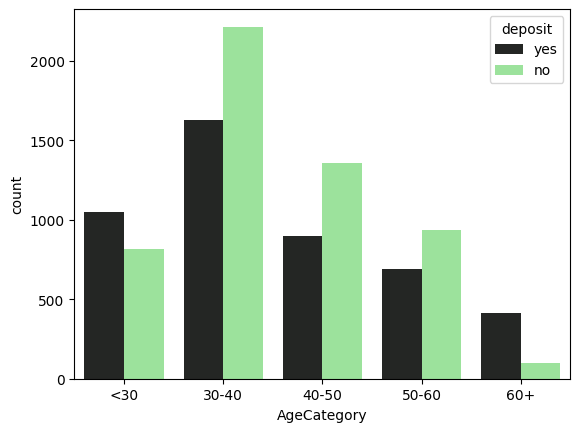

In [490]:
# Построим график:

sns.countplot(data = data,
              x = 'AgeCategory', hue = 'deposit',
              orient = 'h',
              color = 'lightgreen',
              stat = 'count',
              legend = 'auto')

# Выводим результат на экран:
plt.show()

In [491]:
pivot_age = data.pivot_table(
    index = 'AgeCategory',
    columns = 'deposit',
    values = 'campaign',    
    aggfunc = 'count')

# Построим многоуровневую столбчатую диаграмму:
fig = px.bar(pivot_age,
    barmode = 'group',
    # Заголовок графика:
    title = '''возрастные группы склонные открывать депозит:''',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )
# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Возраст клиентов:')
fig.update_yaxes(title_text = 'Количество клиентов:')

# Выводим результат на экран:
fig.show()

### Задания 9 и 10

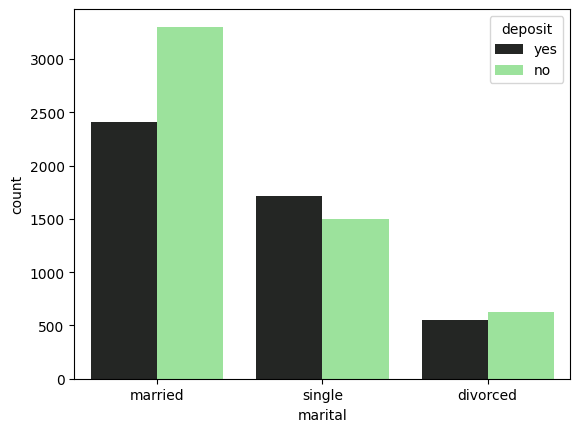

In [492]:
# Постройте визуализации для открывших и неоткрывших депозит
# в зависимости от семейного статуса:

data.groupby('deposit')['marital'].value_counts()

sns.countplot(data = data,
              x = 'marital', hue = 'deposit',
              orient = 'h', color = 'lightgreen',
              stat = 'count',
              legend = 'auto')

# Выводим результат на экран:
plt.show()

In [493]:
# Создаем сводную таблицу:

df_deposit = data.pivot_table(index = 'marital',
    columns = 'deposit',
    values = 'job',
    aggfunc = 'count'
    )

# Построим многоуровневую столбчатую диаграмму:
fig = px.bar(df_deposit,
    barmode = 'group',
    # Заголовок графика:
    title = '''Зависимость открывших и неоткрывших депозит от семейного статуса:''',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )
# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Количество депозитов:')
fig.update_yaxes(title_text = 'Количество клиентов:')
# Выводим результат на экран:
fig.show()

In [494]:
# постройте визуализации для открывших и неоткрывших депозит
# в зависимости от образования:

data.groupby('deposit')['education'].value_counts()

deposit  education
no       secondary    3066
         tertiary     1526
         primary       832
yes      secondary    2451
         tertiary     1713
         primary       517
Name: count, dtype: int64

In [495]:
# Создаем сводную таблицу:

df_education = data.pivot_table(index = 'education',
    columns = 'deposit',
    values = 'job',
    aggfunc = 'count'
    )

# Построим многоуровневую столбчатую диаграмму:
fig = px.bar(df_education,
    barmode = 'group',
    # Заголовок графика:
    title = '''Зависимость открывших и неоткрывших депозит от образования:''',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )
# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Количество депозитов:')
fig.update_yaxes(title_text = 'Количество клиентов:')
# Выводим результат на экран:
fig.show()

In [496]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости
# от вида профессиональной занятости:

data.groupby('deposit')['job'].value_counts()

deposit  job          
no       management       1180
         blue-collar      1155
         technician        900
         admin.            672
         services          523
         retired           231
         self-employed     197
         entrepreneur      189
         housemaid         153
         unemployed        143
         student            81
yes      management       1135
         technician        738
         blue-collar       652
         admin.            574
         retired           432
         services          345
         student           245
         unemployed        189
         self-employed     161
         entrepreneur      111
         housemaid          99
Name: count, dtype: int64

In [497]:
# Создаем сводную таблицу:

df_job = data.pivot_table(index = 'job',
    columns = 'deposit',
    values = 'education',
    aggfunc = 'count'
    )

# Построим многоуровневую столбчатую диаграмму:
fig = px.bar(df_job,
    barmode = 'group',
    # Заголовок графика:
    title = '''Зависимость открывших и неоткрывших
депозит от вида профессии:''',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )
# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Количество депозитов:')
fig.update_yaxes(title_text = 'Количество клиентов:')
# Выводим результат на экран:
fig.show()

### Задание 11

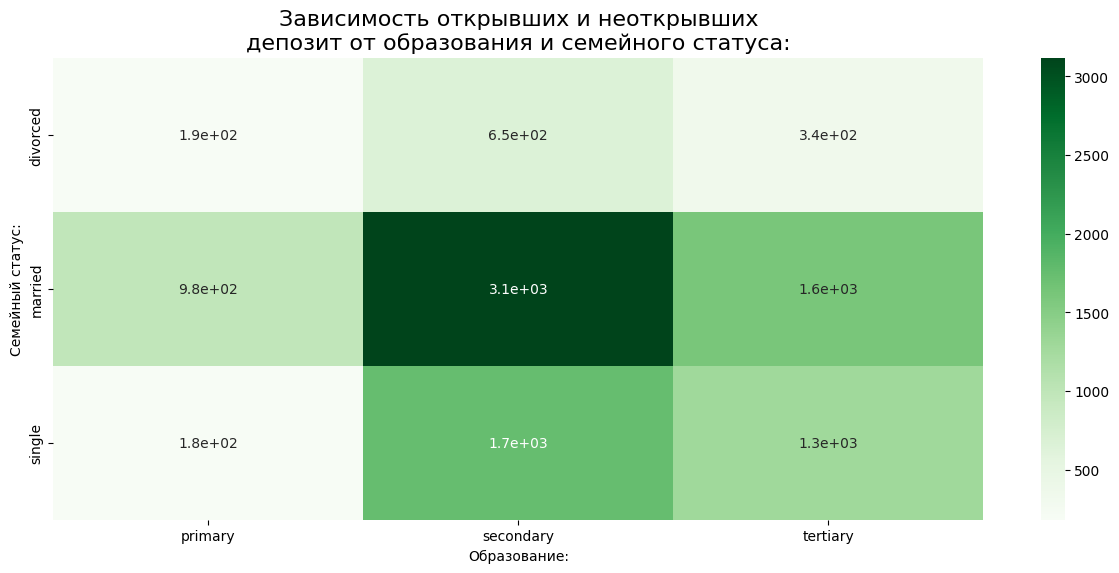

In [498]:
# постройте сводную таблицу, чтобы определить люди с каким образованием
# и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

# pivot = data.groupby('deposit')[['education', 'marital']].value_counts()

# Создаем сводную таблицу:

pivot = data.pivot_table(index = 'marital',
    columns = 'education',
    values = 'deposit',
    aggfunc = 'count'
    )

# На основе полученной сводной таблицы построим
# тепловую карту с аннотацией:
fig = plt.figure(figsize = (15, 6))
heatmap = sns.heatmap(data = pivot, annot = True, cmap = 'Greens')
# Заголовок графика:
heatmap.set_title('''Зависимость открывших и неоткрывших
депозит от образования и семейного статуса:''', fontsize = 16)
# Присваиваем заголовки осей координат:
heatmap.set(xlabel = 'Образование:', ylabel = 'Семейный статус:')
# Выводим результат на экран:
plt.show()

## Часть 3: преобразование данных

### Задание 1

In [499]:
# Преобразуйте уровни образования:

labelencoder = LabelEncoder()

data['education'] = labelencoder.fit_transform(data['education'])
data['education'].sum()

11995

### Задания 2 и 3

In [500]:
# Преобразуйте бинарные переменные в представление из нулей и единиц:
# Кодируем признак 'deposit':

data['deposit'] = data['deposit'].map({"yes": 1, "no": 0})
print(round(data['deposit'].std(),3))

0.499


In [501]:
# Кодируем признак 'default':

data['default'] = data['default'].map({"yes": 1, "no": 0})
print(round(data['default'].mean(),3))

0.016


In [502]:
# Кодируем признак 'housing':

data['housing'] = data['housing'].map({"yes": 1, "no": 0})
print(round(data['housing'].mean(),3))

0.481


In [503]:
# Кодируем признак 'loan':

data['loan'] = data['loan'].map({"yes": 1, "no": 0})
print(round(data['loan'].mean(),3))

0.138


### Задание 4

In [504]:
# Cоздайте дамми-переменные:
# Кодируем признаки методом OneHotEncoding:

data = pd.get_dummies(data, columns = ['job', 'marital', 'contact', 'month', 'poutcome'],
                      dtype = int)
data.shape

(10105, 46)

### Задания 5 и 6

Text(0.5, 1.0, 'Тепловая карта корреляции числовых признаков:')

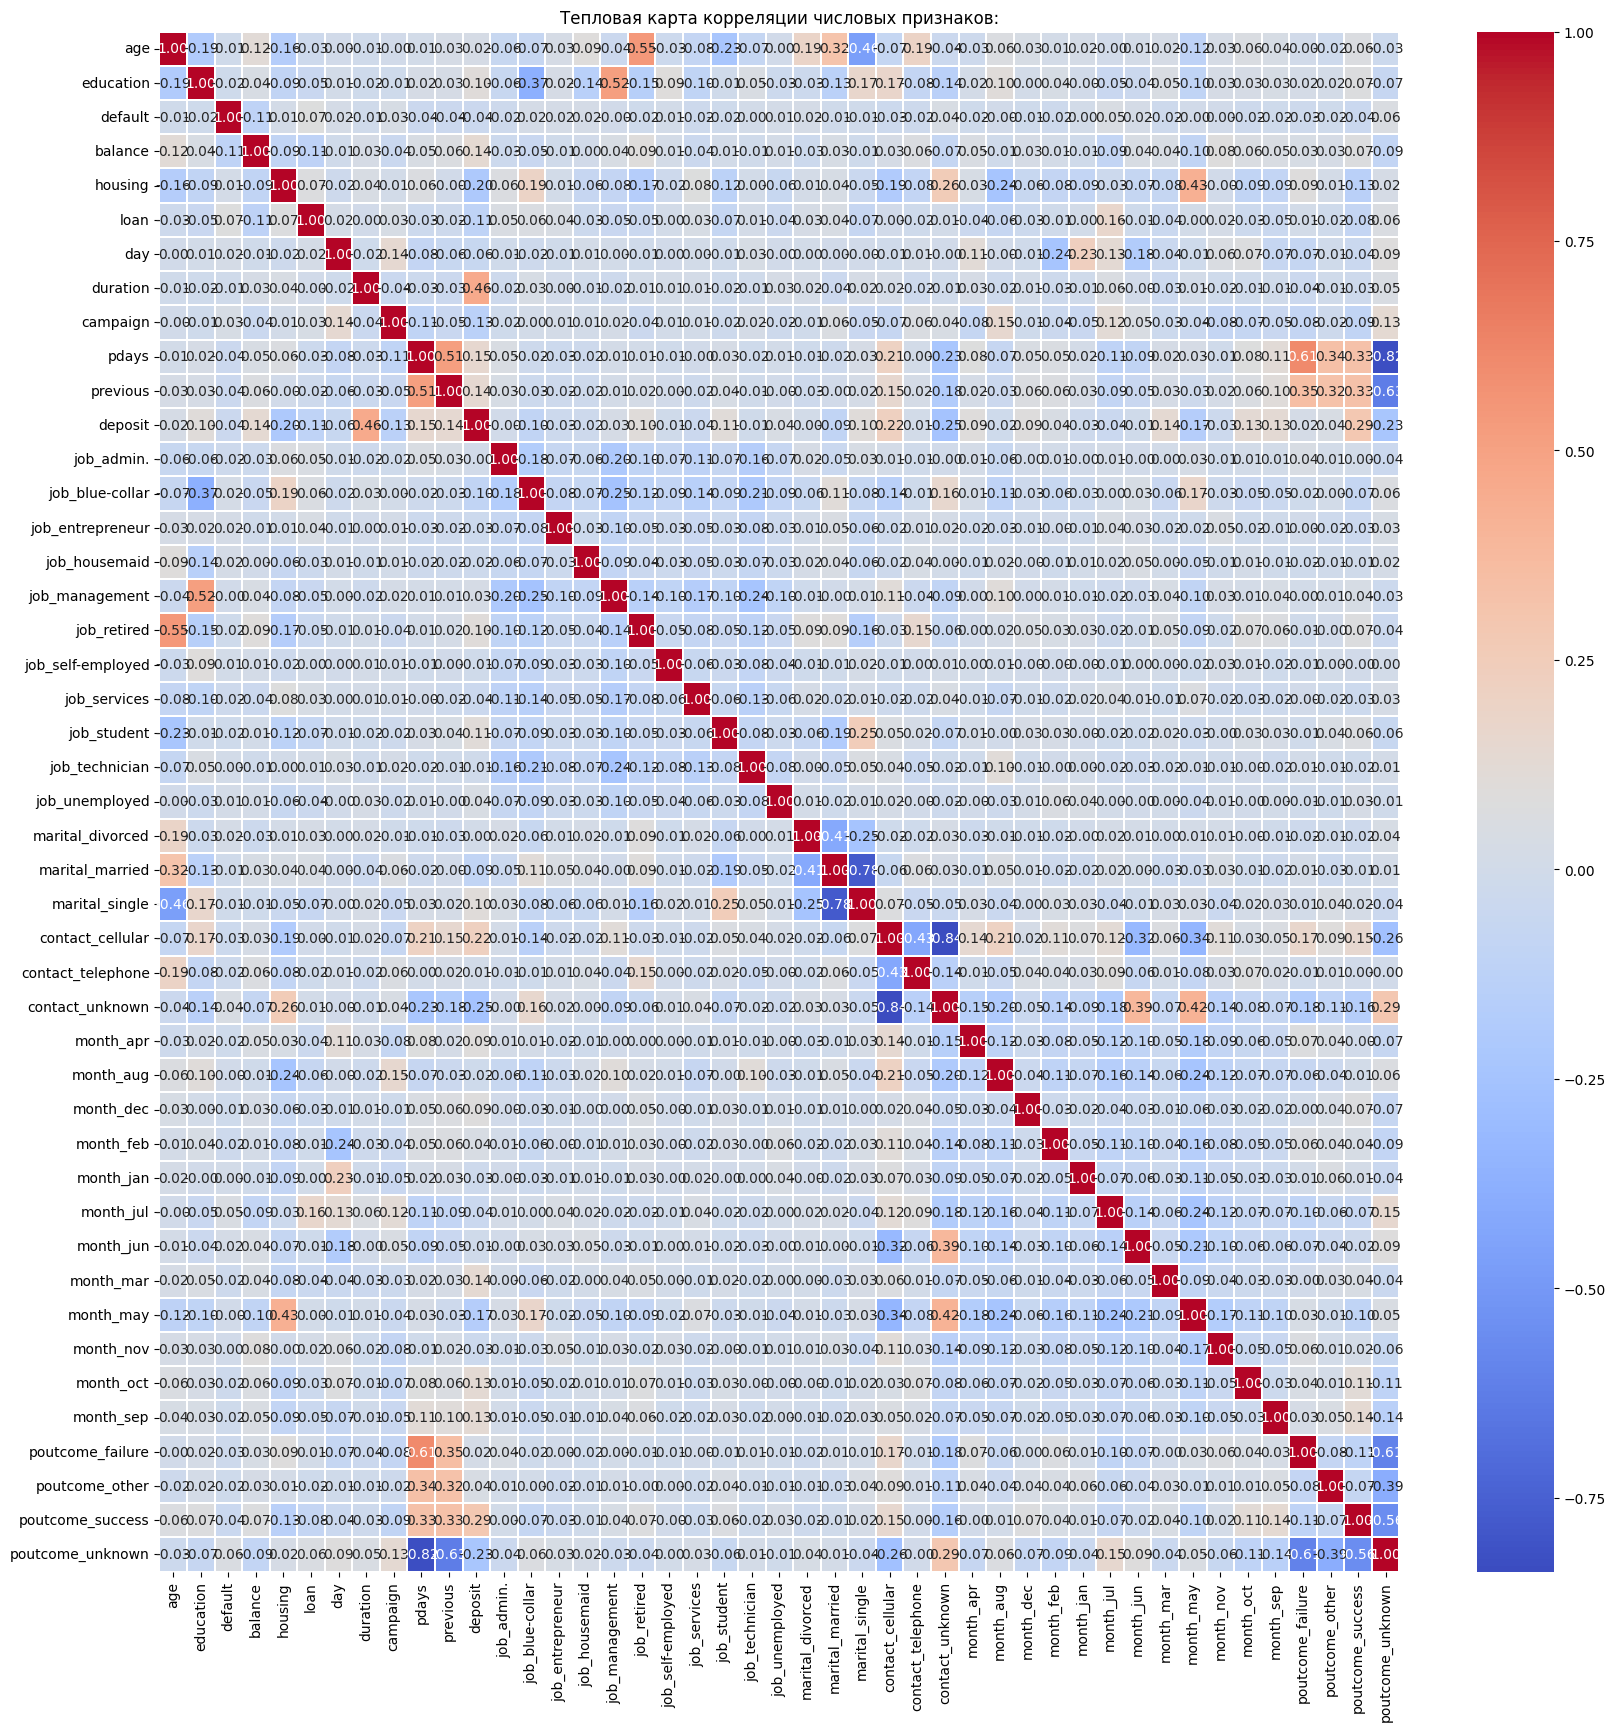

In [505]:
# Постройте корреляционную матрицу и оцените данные
# на предмет наличия мультиколлинеарности:

# Удаляем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "category" обучаться не будет,
# просто выберим их и удалим:

object_columns = [s for s in data.columns if data[s].dtypes == 'category']
data.drop(object_columns, axis = 1, inplace=True)

fig = plt.figure(figsize = (20,20))
ax = sns.heatmap(data.corr(), fmt='.2f', linewidths=.1,
                 cmap='coolwarm', annot=True)
ax.set_title('Тепловая карта корреляции числовых признаков:')

In [506]:
# fig = plt.figure(figsize = (20,20))
# ax = sns.heatmap(data.corr(), fmt='.2f', linewidths=.1,
#                  cmap='coolwarm', annot=True)
# ax.set_title('Тепловая карта корреляции числовых признаков:')
# corr['deposit'].apply(lambda x: x).sort_values()[-5:1].plot.barh()
# plt.show()

### Задания 7 и 8

In [507]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, random_state = 42,
                                                    test_size = 0.33)

In [508]:
# рассчитайте необходимые показатели:

print('Test shape: {}'.format(X_test.shape))
print('Train shape: {}'.format(X_train.shape))

Test shape: (3335, 44)
Train shape: (6770, 44)


### Задание 9

In [509]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков:

selector = SelectKBest(f_classif, k=15)
selector.fit(X, y)
selector.fit(X_train, y_train)
X.columns[selector.get_support(indices=True)].tolist()

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [524]:
# нормализуйте данные с помощью minmaxsxaler:

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

# Масштабируем признаки обучающей выборки:
X_train_scaled = scaler.transform(X_train)

# Преобразуем тестовые данные рассчитанных на обучающей выборке:
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled[:,0].mean())

0.30879760119940036


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [511]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [512]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [513]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [514]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [515]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [516]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [517]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [518]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna